In [1]:
import sys
import os
import random
import csv
from pprint import pprint

module_path = os.path.abspath(os.path.join("..", ".."))
sys.path.append(module_path)

from perceptron.model import Model, train, cross_validate
from perceptron.layer import Layer
from perceptron.dropout import Dropout
from perceptron.activation import (
    Heavyside,
    Linear,
    Relu,
    LeakyRelu,
    Sigmoid,
    Tanh,
    Softmax,
)
from perceptron.data_util import transpose, to_binary

from examples.visualization_utils import histories_plot


In [2]:
%config InlineBackend.figure_formats = ['svg']


In [3]:
with open("sonar.csv", "rt") as f:
    data = [
        [float(value) for value in features] + [target]
        for *features, target in [line for line in csv.reader(f) if line]
    ]

*features, targets = transpose(data)
features = transpose(features)
mapping, targets = to_binary(targets)

print("Labels mapping:")
for label in mapping:
    print(label, mapping[label])


Labels mapping:
M 0
R 1


# Single layer model

Training: 100% |████████████████████████████████████████| 500/500, binary_accuracy=0.995, loss=0.112


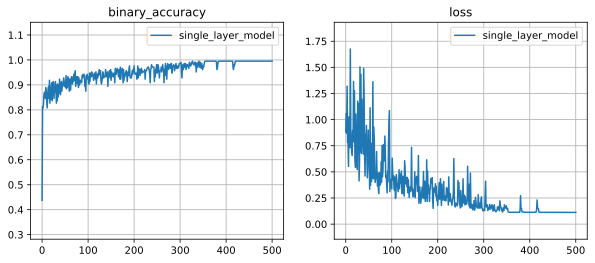

In [4]:
random.seed(0)


def model_factory():
    input_size = 60
    layer_init_method = "he"

    model = Model(normalizer="zscore")

    model.add(Layer(input_size, layer_size=1, init_method=layer_init_method))
    model.add(Sigmoid())

    return model


optimizer = "adam"
model = model_factory()
model.compile(optimizer)

metrics = ["binary_accuracy"]
epochs = 500
history = train(
    model=model,
    training_inputs=features,
    training_targets=targets,
    epochs=epochs,
    loss_function="binary_crossentropy",
    batch_size=2,
    base_learning_rate=0.2,
    learning_rate_decay="linear",
    metrics=metrics,
)


histories_plot({"single_layer_model": history})


# Multi-layer model

Training: 100% |████████████████████████████████████████| 50/50, binary_accuracy=0.851, loss=0.467


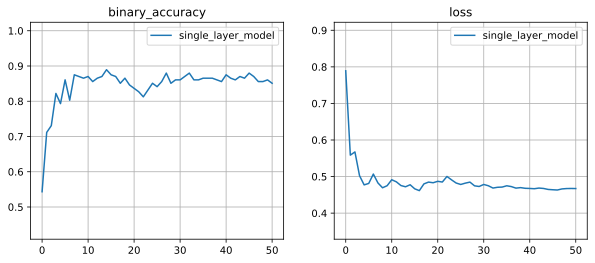

In [5]:
random.seed(0)


def model_factory():
    input_size = 60
    layer_init_method = "he"
    regularizers = {
        "l1_weights_regularizer": 0.005,
        "l1_biases_regularizer": 0.005,
        "l2_weights_regularizer": 0.05,
        "l2_biases_regularizer": 0.05,
    }
    model = Model(normalizer="zscore")

    model.add(Layer(input_size, layer_size=3, **regularizers))
    model.add(Dropout(1 / 3))
    model.add(LeakyRelu())
    model.add(Layer(input_size=3, layer_size=1, **regularizers))
    model.add(Sigmoid())

    return model


optimizer = "momentum"
model = model_factory()
model.compile(optimizer)

metrics = ["binary_accuracy"]
epochs = 50
loss_function = "binary_crossentropy"
batch_size = 32
base_learning_rate = 0.1
learning_rate_decay = "timebased"

history = train(
    model=model,
    training_inputs=features,
    training_targets=targets,
    epochs=epochs,
    loss_function=loss_function,
    batch_size=batch_size,
    base_learning_rate=base_learning_rate,
    learning_rate_decay=learning_rate_decay,
    metrics=metrics,
)


histories_plot({"single_layer_model": history})


# Cross validating multi-layer model

Training: 100% |████████████████████████████████████████| 50/50, binary_accuracy=0.913, l1_loss=0.055, l2_loss=0.106, loss=0.435, val_binary_accuracy=0.786, val_loss=0.54  
Training: 100% |████████████████████████████████████████| 50/50, binary_accuracy=0.921, l1_loss=0.0582, l2_loss=0.117, loss=0.37, val_binary_accuracy=0.754, val_loss=0.541 
Training: 100% |████████████████████████████████████████| 50/50, binary_accuracy=0.871, l1_loss=0.0567, l2_loss=0.114, loss=0.405, val_binary_accuracy=0.87, val_loss=0.462 


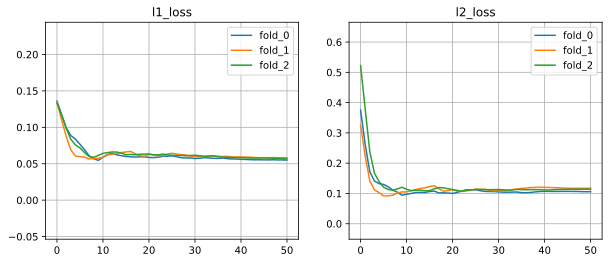

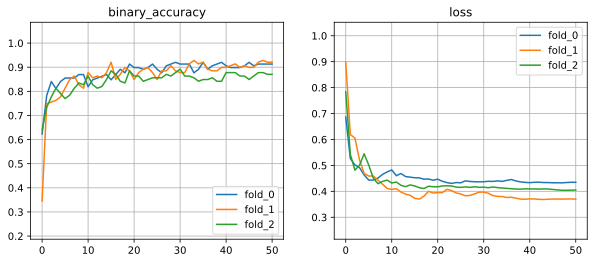

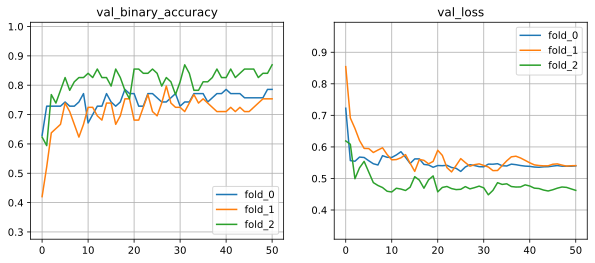

In [6]:
random.seed(0)

histories = cross_validate(
    model_factory=model_factory,
    inputs=features,
    targets=targets,
    fold_count=3,
    optimizer=optimizer,
    epochs=epochs,
    loss_function=loss_function,
    batch_size=batch_size,
    base_learning_rate=base_learning_rate,
    learning_rate_decay=learning_rate_decay,
    metrics=metrics,
    include_l1_loss_in_history=True,
    include_l2_loss_in_history=True,
)

histories_plot(histories, names=["l1_loss", "l2_loss"])
histories_plot(histories, names=["binary_accuracy", "loss"])
histories_plot(histories, names=["val_binary_accuracy", "val_loss"])
